## CS 889 Assignment 03
### Yuwei Jiao 20645480

### Objective 1
### description:
- problem:
    1. not clear enough about to what extent we need to clean up the raw image.
    2. tuning parameters in morphological opening and closing.
    3. results show it has good performance on still background, e.g. the wall and desk, but for sleeping sheets the result is not good enough because it's easy to move slightly.
- resources: 
    1. use this [link][1] for keycode
[1]: (https://css-tricks.com/snippets/javascript/javascript-keycodes/)

In [1]:
%matplotlib inline
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from helpers import imshow

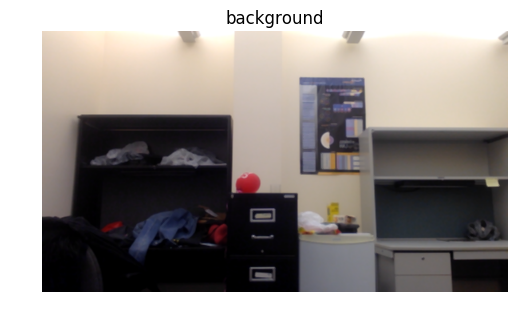

In [2]:
camera = cv2.VideoCapture(0)
blurKernel = np.ones((5,5),np.float32) / 25
morKernel = np.ones((3,3),np.uint8) / 9
iterations = 3
while iterations > 0:
    iterations -= 1
    flag = False
    while True:
        ret, ori = camera.read()
        # mirror symmetry
        ori = np.fliplr(ori)
        frame = ori.copy()
        # filter
        frame = cv2.filter2D(frame, -1, blurKernel)
        # blur
        frame = cv2.medianBlur(frame,5)
        if flag:
            # change image to grayscale
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # calculate absolute difference between real time image and background
            distance = cv2.absdiff(frame, background)
            # extract objects
            ret, th1 = cv2.threshold(distance, 45, 255, cv2.THRESH_BINARY)
            processed = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, morKernel, iterations = 5)
            processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, morKernel, iterations = 2)
            # show image
            cv2.imshow('foreground', processed)
        else:
            cv2.imshow('original', frame)
        key = cv2.waitKey(5)
        if key == 32 and not flag: # space: record current image as background
            background = frame
            flag = True;
            imshow(background, 'background')
            background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
        elif key == 13: # enter: print both images
            imshow(ori, 'original')
            imshow(processed, 'forground')
        elif key == 27: # esc: exit
            break;
cv2.destroyAllWindows()
camera.release()

### Objective 2
### description:
- problem:
    1. some issues about how to find blobs, how to calculate areas and positions and which one to track.
    2. tune parameter to eliminate noises.
- resources: 
    1. use this [link][1] to learn contour features in opencv.
[1]: (https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html#contour-features)

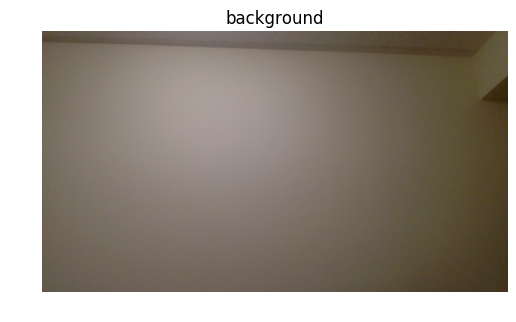

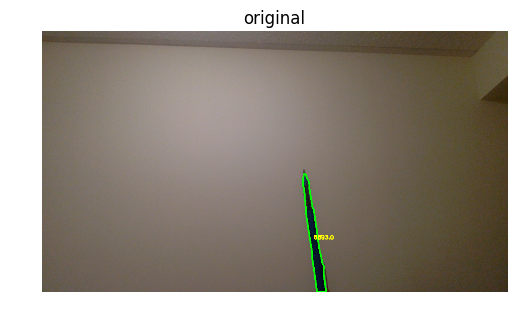

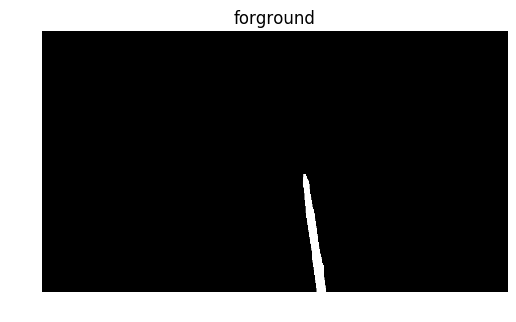

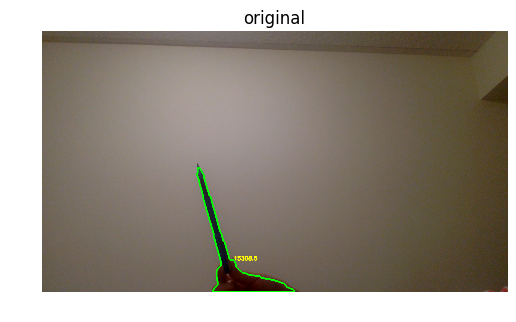

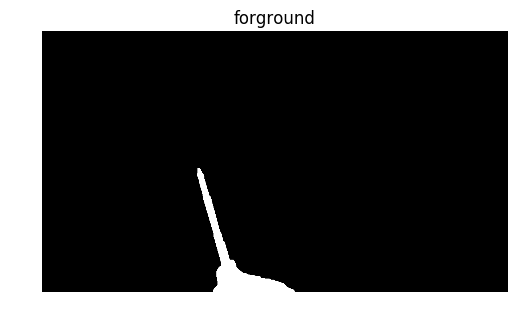

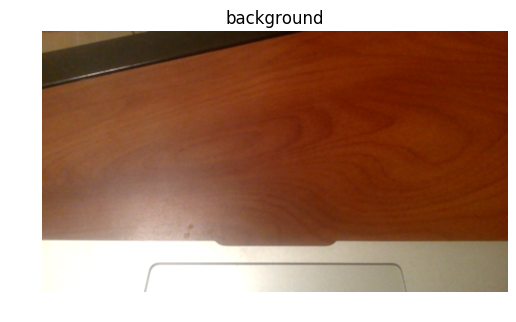

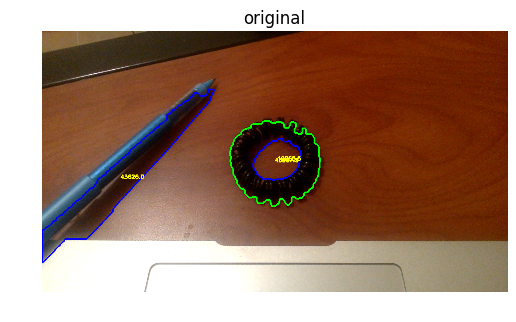

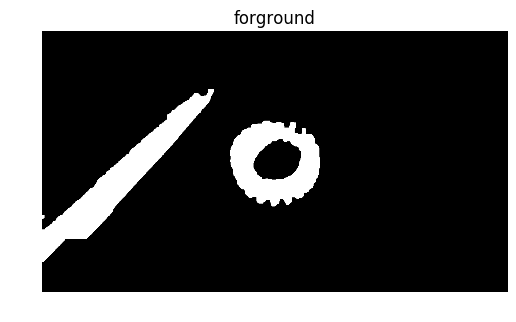

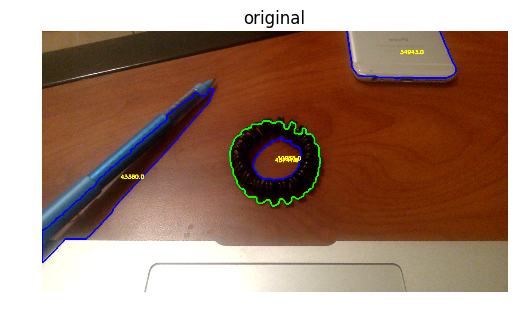

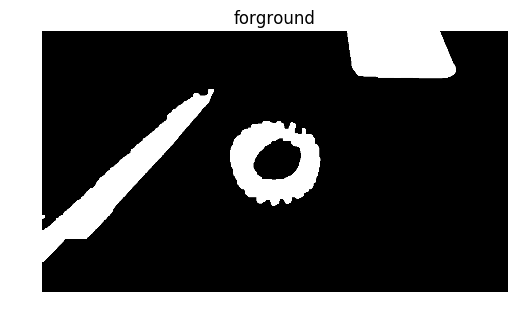

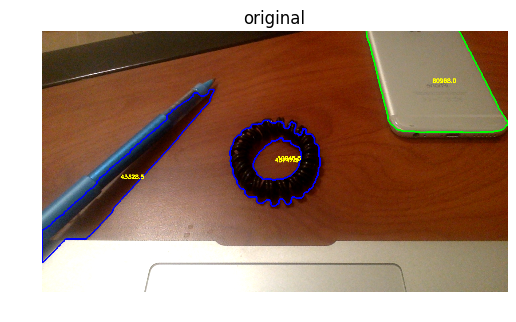

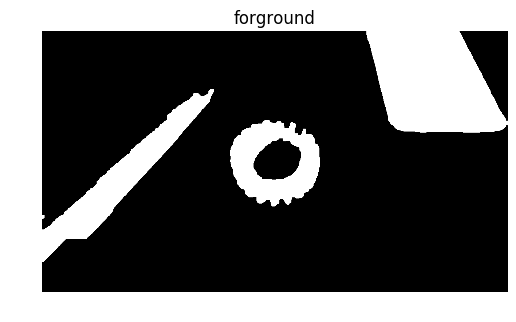

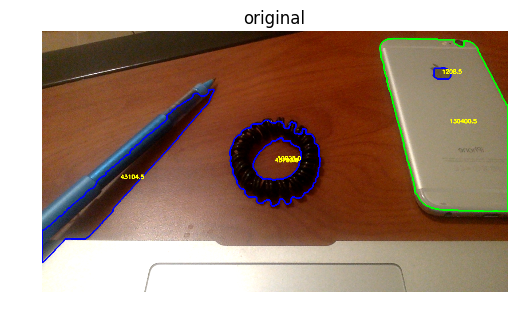

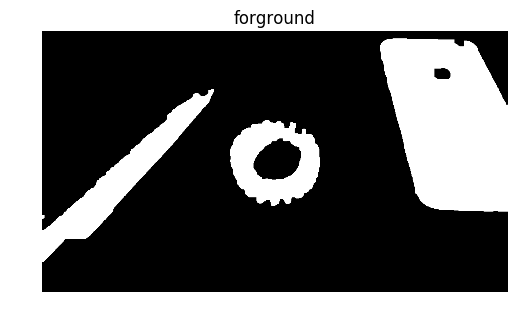

In [2]:
camera = cv2.VideoCapture(0)
blurKernel = np.ones((5,5),np.float32) / 25
morKernel = np.ones((3,3),np.uint8) / 9
font = cv2.FONT_HERSHEY_SIMPLEX
iterations = 2
while iterations > 0:
    iterations -= 1
    flag = False
    while True:
        ret, ori = camera.read()
        # mirror symmetry
        ori = np.fliplr(ori)
        frame = ori.copy()
        # filter
        frame = cv2.filter2D(frame, -1, blurKernel)
        # blur
        frame = cv2.medianBlur(frame,5)
        if flag:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            distance = cv2.absdiff(frame, background)
            ret, th1 = cv2.threshold(distance, 45, 255, cv2.THRESH_BINARY)
            processed = cv2.morphologyEx(th1, cv2.MORPH_CLOSE, morKernel, iterations = 4)
            processed = cv2.morphologyEx(processed, cv2.MORPH_OPEN, morKernel, iterations = 3)
            # find contours
            image, contours, hierarchy = cv2.findContours(processed, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            image = ori.copy()
            size = len(contours)
            if size == 0:
                continue
            # calculate the areas for all blobs and select the largest
            areas = []
            for cnt in contours:
                area = cv2.contourArea(cnt)
                areas += [area]
            maxarea = max(areas)
            for i in range(0, size):
                cnt = contours[i]
                area = areas[i]
                # eliminate small noises
                if area < 1000:
                    continue
                # track aim object with the largest size
                # green for tracked object and blue for normal
                if area == maxarea:
                    cv2.drawContours(image, [cnt], 0, (0, 255, 0), 3)
                else:
                    cv2.drawContours(image, [cnt], 0, (255, 0, 0), 3)
                M = cv2.moments(cnt)
                position = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
                cv2.putText(image, str(area), position, font, 0.5,(0, 255, 255), 2)
            # show image
            cv2.imshow('foreground', image)
        else:
            cv2.imshow('original', frame)
        key = cv2.waitKey(5)
        if key == 32 and not flag: # space
            background = frame
            flag = True;
            imshow(background, 'background')
            background = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
        elif key == 27: # esc
            break;
        elif key == 13: # enter
            imshow(image, 'original')
            imshow(processed, 'forground')
cv2.destroyAllWindows()
camera.release()